# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports
#import gc
#gc.collect()

In [2]:
DEBUG = True#False#True
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0, K_iters_alpha_drop=500, gamma=.90, do_reflection=True):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        #np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        
        #Stepwise exponentially decaying learning rate:
        #every K iterations, learning rate alpha is multiplied
        #by 0<gamma<=1
        #To NOT do this and just use constant alpha,
        #just set gamma = 1 [or K bigger than you would ever reach]
        self.K_iters_alpha_drop = K_iters_alpha_drop#500
        self.gamma = gamma#.90
        
        #Counter used for debugging and updating alpha
        self.iterations_finished = 0
        
        #The weights and biaseswe are optimizing
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.data_loss = []
        self.regularization_loss = []
        self.weights_means = []
        self.dW_means = []
        self.weights_sds = []
        self.dW_sds = []        
        
        #Whether to do left/right reflection
        self.do_reflection = do_reflection
        
                
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        """
        
        
        
    def LeftRightReflection(self, X_batch, y_batch, prob_reflect=.5):
        """
        As basic form of data augmentation,
        reflect images left-right with some probability.
        
        Only left-right since in many of the cifar images,
        there is a clear up-down direction because of real
        world gravity. So also doing up-down reflection 
        would be artificial. SO only do left-right.
        
        Technically it would be better to only have
        either image or image' in a given batch (to
        not have both the image and its reflection, 
        because both in the same batch way introduce
        bad symmetries). But just try this for now, and
        use a probability so that not every image has
        its reflection.
        
        --> Actually, at first, just relfect all images 
        and se what happens...
        """
        
        #t=X_train[:,:5]
        #print(t.shape)
        #g=[i.reshape(32,32,3) for i in t.T]
        #plt.figure()
        #plt.imshow(g[0])
        #plt.show()
        #h=[np.fliplr(i) for i in g]
        #plt.figure()
        #plt.imshow(h[0])
        #plt.show()
        #j=np.vstack(([i.flatten() for i in h])).T
        #print(j.shape)
        #print(t[:,0])
        #print(j[:,0])
        #_,u1 = np.unique(t[:,0],return_counts=True)
        #_,u2 = np.unique(j[:,0],return_counts=True)
        #print(u1==u2)
        
        
        #P = np.random.binomial(1, 1.-prob, size=X_batch.shape[1]).astype(int)
        #P = boolean(P)
        #X_additional = X_batch[:,P]
        
        #b = X_batch.shape[1]
        
        #Reshape data, reflect left right, reshape back
        aa=np.vstack(([np.fliplr(i.reshape(32,32,3)).flatten() for i in X_batch.T])).T
        #Append reflected data/labels to originals
        X_batch = np.hstack((X_batch,aa))
        y_batch = np.tile(y_batch,2)
        
        
        #Verify everything correct reflection and label:
        #plt.figure()
        #plt.imshow(X_batch.T[0].reshape(32,32,3))
        #plt.show()
        #print(y_batch[0])
        #plt.figure()
        #plt.imshow(X_batch.T[b].reshape(32,32,3))
        #plt.show()
        #print(y_batch[b])        
        
        
        #Update the batch_size since now is potentilly larger
        batch_size = X_batch.shape[1]
        #print(batch_size)

        return X_batch, y_batch, batch_size

    
    
    def PreprocessInput(X_batch):
        """
        Do standard scaling; or do whitening on the data.
        
        In training, just do on the individual batch.
        But keep track of the statistics over all batches.
        Then at test time, use full statistics.
        """
        
        
        
        
    def visualizeActivations(self,activations):
        """
        Visualize activations for debugging
        """
        N = len(activations)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Activations')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(activations[i].flatten(),bins=50)
            print('Activations', i, 'Mean', activations[i].flatten().mean(), 'SD', activations[i].flatten().std(), \
                  'Min', activations[i].flatten().min(), 'Max', activations[i].flatten().max())
        plt.show()
        
        
    
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten(),bins=50)
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten(),bins=50)
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        
        #Just make plots of means / sds since easier to see than these histograms
        """
        fig=plt.figure()
        plt.title('Weights')
        clist = ['r','g','b','k','c','m']
        for i in range(N):
            fig.plot(self.weights_means[i],,marker='o',color=clist[i],label='Loss')
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()      
        """
        
        plt.figure()
        plt.title('Loss vs Iteration')
        plt.plot(self.data_loss,marker='o',color='b',label='Data Loss')
        if self.reg_lambda > 0.:
            plt.plot(self.regularization_loss,marker='o',color='r',label='Regularization Loss')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x10)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        #rng = np.random.RandomState(123)
        #M = rng.binomial(size=A.shape,
        #                    n=1,
        #                    p=1-prob)
        
        M = np.random.binomial(1, 1.-prob, size=A.shape)
        #print(M)
        
        A *= M
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
            #print(len(cache['weights']))
            #print(cache['weights'][0].shape)
            #print(cache['weights'][1].shape)
            #print(cache['weights'][2].shape)
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                #Try Xavier-Glorot initialization [http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf]:
                SD_glorot = np.sqrt(2. / (self.parameters['layerDimensions'][layer]+self.parameters['layerDimensions'][layer - 1]))
                #Try MSRA initialization [https://arxiv.org/pdf/1502.01852.pdf]:
                SD_MSRA = np.sqrt(2. / self.parameters['layerDimensions'][layer - 1])
                #SD = SD_MSRA
                #SD = SD_glorot
                SD = .01
                W = np.random.normal(0., SD, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer (index self.num_layers-1):
            #(Also we don't do ReLU onqt layer, but that's already taken 
            #care of because we do range(1,...) )
            A = self.activationForward(Z) if layer!=self.num_layers-1 else Z
            
            if self.drop_prob > 0:
                A, M = self.dropout(A,self.drop_prob)
                cache['dropoutMasks'].append(M)
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param self.reg_lambda: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """

        epsilon = 10e-9 #10e-5 #10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        
        #Original, no clipping
        #softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        
        #Nan to num cliping:
        softmax_out = np.nan_to_num(np.exp(AL))/(np.nan_to_num(np.exp(AL).sum(axis=0))+epsilon)
        
        #if 0's in softmax out, will get infs in cost, so clip to epsilon
        softmax_out = softmax_out.clip(min=10e-20)
        
        #Need to know if there are nans/infs:
        if DEBUG:
            #nans_present = np.isnan(np.exp(AL)).any()
            #infs_present = np.isinf(np.exp(AL)).any()
            #if nans_present:
            #    raise ValueError('nans in exp(AL)')
            #if infs_present:
            #    raise ValueError('infs in exp(AL)')
            if np.isnan(softmax_out).any():
                raise ValueError('nans in softmax function')
            if np.isinf(softmax_out).any():
                raise ValueError('infs in softmax function')
            if (softmax_out==0.).any():
                raise ValueError('zeros in softmax function')
                

                
        #Manual clipping
        #max_val = 10e3
        #softmax_out = np.exp(AL).clip(0.,max_val)/(np.exp(AL).clip(0.,max_val).sum(axis=0)+epsilon)
        
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        #cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...
        cost = (-1./S)*np.sum(np.log(softmax_out))
        self.data_loss += [cost]
        
        #Need to know if there are nans/infs:
        #With the nan/inf/0 handling above, there should never be any problems with cost function
        #unless there is overflow in log function:
        if DEBUG:
            nans_present = np.isnan(np.log(softmax_out)).any()
            infs_present = np.isinf(np.log(softmax_out)).any()
            if nans_present:
                raise ValueError('nans in cost function')
            if infs_present:
                raise ValueError('infs in cost function')
                
                
        
        #Also get the regularization cost:
        if self.reg_lambda > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_loss += [reg_cost]
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda > 0:
            dW += self.reg_lambda*W #For now assuming only L2 reg.
        
        #d_output / db = I(if i)
        db = np.ones(cache['biases'][layer-1].shape)
        
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        # TODO    
        #if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        AL, _ = self.forwardPropagation(X)
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        if DEBUG:
            print(y_pred)
            print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        #Split training data into training and validation set (90/10 split):
        train_inds = np.random.choice(X.shape[1],int(X.shape[1]*.90),replace=False)
        validation_inds = np.setdiff1d(np.arange(X.shape[1]),train_inds)
        X_training = X[:,train_inds]
        y_training = y[train_inds]
        X_validation = X[:,validation_inds]
        y_validation = y[validation_inds]
        #print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)
        
        
        #Do training iterations
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X_training, y_training, batch_size)
            
            #Left right reflection as form of data augmentation
            if self.do_reflection:
                X_batch, y_batch, batch_size = self.LeftRightReflection(X_batch, y_batch, prob_reflect=.5)
                #print(X_batch.shape, y_batch.shape, batch_size)
            
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)
            
            #For debugging, look at activations [do here before popped off in backprop]
            if DEBUG and i % 100 == 0:
                self.visualizeActivations(cache['activations'])

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # update weights and biases based on gradient
            #print(self.iterations_finished)
            #print('alpha',alpha)
            #This learning rate alpha will decay step exponentially [every K iters, multiply by 0<gamma<=1]
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            #Iteration counter
            self.iterations_finished += 1
            
            #Lower the learning rate every K iterations.
            #Just use an exponential decay here: alpha' = alpha*gamma^(floor(i/K))
            if self.iterations_finished % self.K_iters_alpha_drop == 0:
                alpha *= self.gamma #decaying stepwise exponentially
            
            
            if i % print_every == 0:
                #Training set accruacy:
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                #Validation set accuracy:
                y_validation_predicted = self.predict(X_validation)
                validation_accuracy = (y_validation_predicted==y_validation).sum()/np.float(y_validation.size)
                print('cost: {0}, train accuracy: {1}, validation accuracy: {2}'.format(
                    cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                
                
                print('iterations finished:', self.iterations_finished, 'alpha:', alpha, 'reg. lambda:', self.reg_lambda)
                print('\n')
                
                
            
            #For debugging, look at weights and gradients on weights
            if DEBUG and i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)


In [3]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [4]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [5]:
# Load the data
data_root_path = 'cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Part 1

#### Simple fully-connected deep neural network

Activations 0 Mean 0.447466681985 SD 0.247665377336 Min 0.0 Max 1.0
Activations 1 Mean 0.121118657848 SD 0.178459020293 Min 0.0 Max 1.12445440172
Activations 2 Mean -0.00499931667137 SD 0.0209162311326 Min -0.0687801911128 Max 0.0565036867816


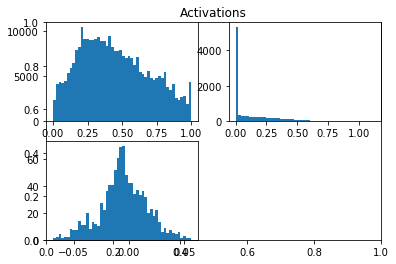

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0 99  0  0  0  0  0  0  0  1]
[1 1 1 ..., 1 1 1]
[  21 4906    1    0    0    2    0    0    2   68]
cost: 23.02801299483487, train accuracy: 0.13, validation accuracy: 0.102
iterations finished: 1 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean 5.20842528099e-06 SD 0.00999915582673
Weights 1 Mean -0.000111101196103 SD 0.0099163639617


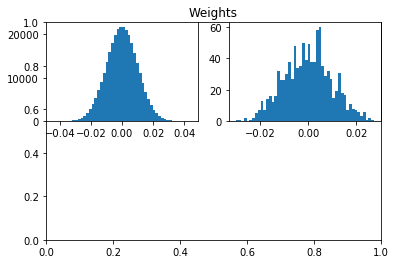

dW 0 Mean 0.00188318209763 SD 0.0362688980176
dW 1 Mean -1.21727971703e-09 SD 0.647012331378


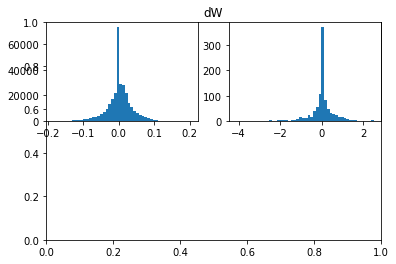

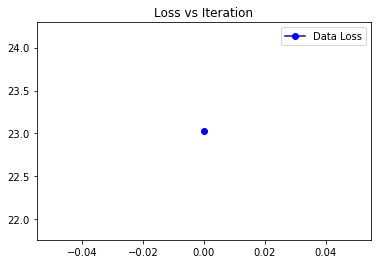

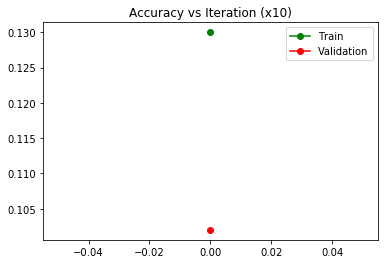

[0 0 0 0 9 9 9 9 0 0 9 0 0 9 0 9 9 0 0 9 0 9 0 0 0 9 9 9 0 0 9 0 0 0 9 0 0
 9 9 0 0 0 0 0 0 0 9 9 9 0 0 9 0 0 0 9 0 7 0 9 0 0 9 0 0 9 0 9 0 0 9 9 0 9
 0 0 9 9 9 0 9 9 0 9 0 0 9 9 9 9 9 9 0 0 0 0 9 0 9 0]
[56  0  0  0  0  0  0  1  0 43]
[0 0 0 ..., 9 0 0]
[2894    0   18    0    0    0    0   28   11 2049]
cost: 23.044058883949848, train accuracy: 0.19, validation accuracy: 0.1502
iterations finished: 11 alpha: 0.001 reg. lambda: 0.0


[8 8 5 5 5 0 5 8 5 8 5 5 5 8 8 8 8 5 5 5 5 5 5 5 8 5 5 5 8 5 8 5 5 5 8 0 5
 8 8 8 8 5 0 8 5 5 5 5 5 5 5 5 8 5 5 5 5 5 5 8 5 5 5 8 8 5 5 5 5 8 5 8 5 8
 8 5 5 8 5 8 5 5 8 8 8 8 5 5 5 8 9 5 8 5 5 8 5 5 8 8]
[ 3  0  0  0  0 60  0  0 36  1]
[5 8 8 ..., 8 5 8]
[ 168    0    0    1    0 2574    0   15 1929  313]
cost: 23.041358053423593, train accuracy: 0.2, validation accuracy: 0.1846
iterations finished: 21 alpha: 0.001 reg. lambda: 0.0


[8 7 8 8 5 8 8 8 8 5 8 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 8 5 5 8 8 8 8 2 8 8 8
 8 8 8 5 8 8 8 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8

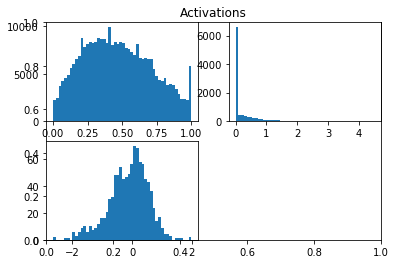

[6 9 9 5 9 8 6 6 3 6 6 9 3 6 9 6 8 7 9 3 3 9 5 6 6 0 9 6 0 6 6 2 9 6 6 8 9
 9 9 6 3 9 3 6 9 6 6 6 1 9 9 3 6 6 9 6 3 9 6 1 6 8 6 9 8 9 6 9 1 6 6 9 9 9
 6 3 8 5 8 8 9 6 6 9 9 9 6 6 9 8 6 6 6 1 1 9 6 8 9 6]
[ 2  5  1  9  0  3 38  1 10 31]
[6 1 1 ..., 1 3 6]
[  36  380   22  197    0  196 1566  168  528 1907]
cost: 24.898883958065145, train accuracy: 0.25, validation accuracy: 0.2184
iterations finished: 101 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean 9.18879611685e-05 SD 0.0102587677141
Weights 1 Mean -0.000111100975501 SD 0.0303783070056


In [ ]:
np.random.seed(123456)
#layer_dimensions = [X_train.shape[0], 100, 100, 50, 10]  # including the input and output layers
layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions, K_iters_alpha_drop=500, gamma=.90, do_reflection=False)
NN.train(X_train, y_train, iters=50000, alpha=0.001, batch_size=100, print_every=10)

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
np.random.seed(777777)
layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
NN2 = NeuralNetwork(layer_dimensions, drop_prob=.25, reg_lambda=.01, K_iters_alpha_drop=500, gamma=.90, do_reflection=False)
NN2.train(X_train, y_train, iters=50000, alpha=0.001, batch_size=100, print_every=10)#alpha=0.00001

In [ ]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni',y_predicted)